## Attacking MNIST Dataset

Here we use a custom NN trained on MNIST data to perform *Frank Wolf Black Box Attack*

## Environment setup

In [1]:
# # Enable this for COLAB execution
# 
# # Dependencies
# from google.colab import drive
# import sys
# import os
# 
# # Mount remote filesystem
# drive.mount('/content/gdrive')
# # Set working directory
# os.chdir('/content/gdrive/path/to/root')

In [2]:
# import torch
# from src.models import MnistNet
# from torchvision import transforms
# from torch import nn, optim

# Common dependencies
# from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

# Torch dependencies
import torch

# Custom dependencies
from src.loss import ZooLoss, MSELoss
from src.FWOptim import FrankWolfe
from src.dataset import MNIST
from src.models import MnistNet

# Set plotting mode
%matplotlib inline

In [3]:
# Get cpu device
cpu = torch.device('cpu')
# Get best device, gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else cpu
device

device(type='cuda')

## Dataset

We retrieve the MNIST data. <br>
The 'standard' *trasnform.compose* method just convert the data to *torch.Tensor* without any rescaling or normalizzation

In [4]:
# Get MNIST dataset with standard transformation
mnist = MNIST(transform='standard')
# Split dataset in train and test
train, test = mnist.get_dataloader(batch_size=250, num_workers=0)


Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([250, 1, 28, 28])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([250])


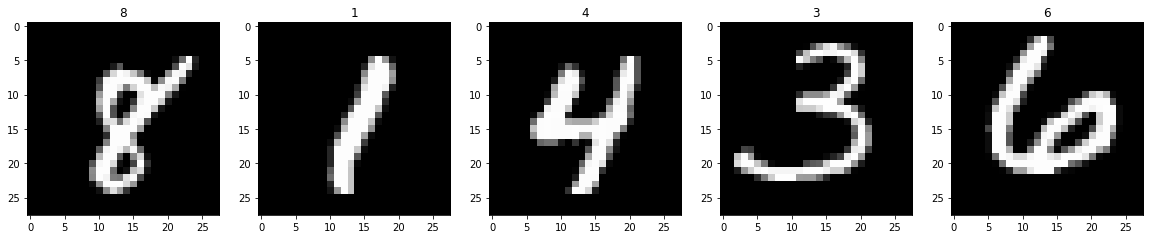

In [5]:
# Get info for train dataset
MNIST.get_info(train)


Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([250, 1, 28, 28])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([250])


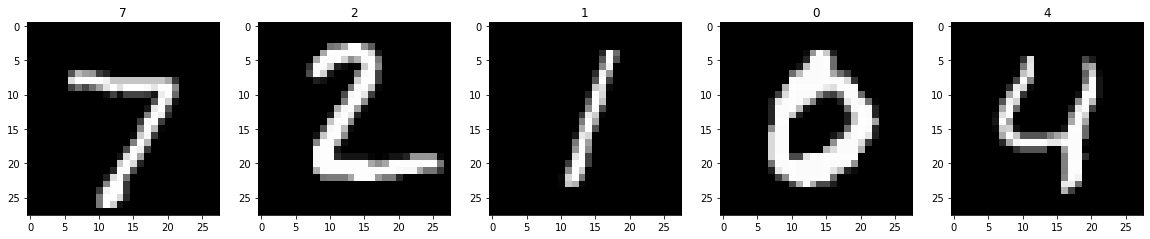

In [6]:
# Get info for test dataset
MNIST.get_info(test)

In [7]:
# DataLoader = data.MNIST(transform='standard')
# train, test = DataLoader.get_dataloader(batch_size=250, num_workers=0)
# DataLoader.get_info()

## Neural Network

In [8]:
# Instantiate a new neural network architecture
net = MnistNet()
# Set pre-trained weights
net.load_state_dict(torch.load('data/models/mnistBaseV2_state_dict.pth'))
# Load neural network to chosen device
net.to(device)
# Set network in evaluation mode
net.eval()

MnistNet(
  (FeatureExtractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 20, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(20, 24, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier): Sequential(
    (0): Flatten()
    (1): Linear(in_features=1536, out_features=256, bias=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [9]:
# device = torch.device('cuda')
# net = MnistNet().to(device)
# net.load_state_dict(torch.load('models/mnistBaseV2_state_dict.pth'))

## Adversarial attack

### Single attack

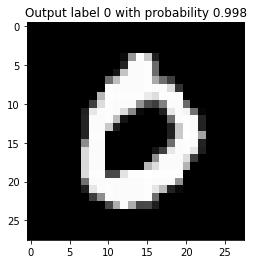

In [10]:
# Get an input used as test
batch = next(iter(test))
# Load X input and y label to device
X, y = batch[0].to(device), batch[1].to(device)

# Get an exaple imput image
img = X[3].cpu().numpy()
# Define output function
out_fn = torch.nn.Softmax(dim=1)
# Get an example output
out = out_fn(net(X[3].reshape(1, 1, 28, 28)))
# Plot output image
plt.imshow(np.transpose(img, (1, 2, 0)).reshape(28, 28), cmap='gray')
# Get original label
original_label = torch.argmax(out).item()
# Make plot
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out[0, original_label])))
plt.show()

### General attack

Here we try to manipulate the input such that it will be misclassified in favor of a whatever class. Usually its easier and we deal with the problem by minimizing the probability of the true class  

E.g. we try to minimize the probability of classification of neuron zero (0)

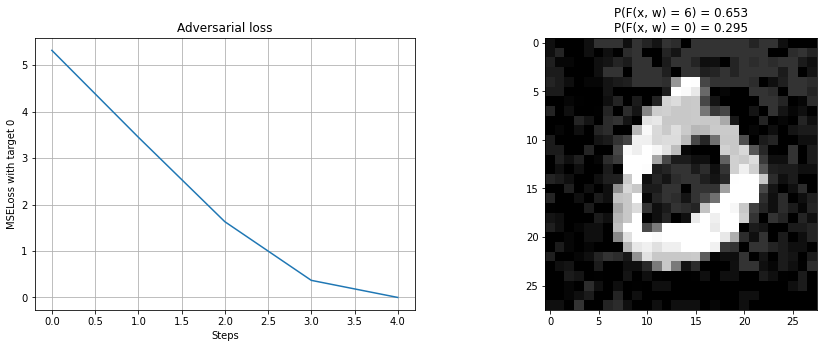

In [11]:
# Define output function
out_fn = torch.nn.Softmax(dim=1)
# Define loss function
loss_fn = ZooLoss(neuron=0, maximise=0)
# Define optimizer
optim = FrankWolfe(net, loss_fn, 'cuda')

# Define optimizer parameters
optim_params = {
    'x': X[3],  # Input variable
    'm_weight': 0.2,  # Momentum weight (1 - gradient weight)
    'step_size': 0.2,  # Step size
    'num_epochs': 100,  # Number of epochs
    'l_bound': 0.3,  # Upper bound for l- norm
    'l_type': 'inf',  # l- norm type
    'grad_num_iter': 600,  # Number of inner iterations for gradient estimation
    'grad_smooth': 0.001,  # Gradient smoothing
    'grad_how': 'sphere',  # Gaussian estimation
    'grad_batch_size': 600,  # Size of the batch used in gradient estimation
    'verbose': False
}

# Disable gradient computation
with torch.no_grad():
    # Run the optimizer
    x, loss, _ = optim.run(**optim_params)
    # Compute last output
    out = out_fn(net(x.reshape(1, 1, 28, 28)))
    label = torch.argmax(out).item()
    img = x.detach().cpu().numpy()

# Show results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('MSELoss with target 0')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(img.reshape(28, 28), cmap='gray')
ax[1].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(label, float(out[0, label]),                                                                            original_label, float(out[0, original_label])))
plt.show()

### General attack

Here we try to manipulate the input such that it will be misclassified in favor of a *specific* class.

E.g. we want to try to maximise the probability of classification of neuron eight (8)

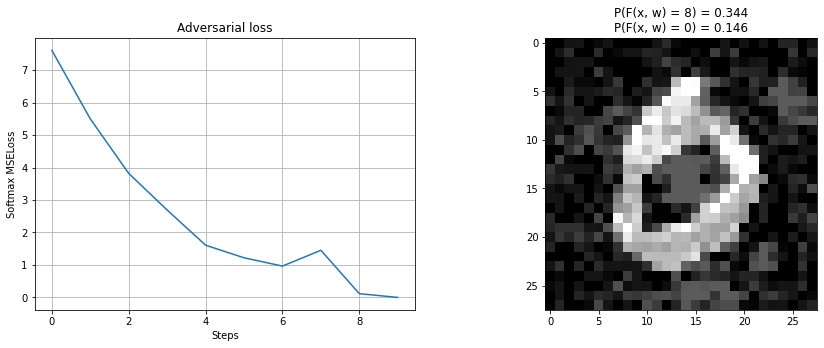

In [21]:
# Redefine loss function
# loss_fn = MSELoss(neuron=8, maximise=1)
loss_fn = ZooLoss(neuron=8, maximise=1)
# Redefine optimizer
optim = FrankWolfe(net, loss_fn, 'cuda')

# Define optimizer parameters
optim_params = {
    'x': X[3],  # Input variable
    'm_weight': 0.2,  # Momentum weight (1 - gradient weight)
    'step_size': 0.2,  # Step size
    'num_epochs': 100,  # Number of epochs
    'l_bound': 0.4,  # Upper bound for l- norm
    'l_type': 'inf',  # l- norm type
    'grad_num_iter': 600,  # Number of inner iterations for gradient estimation
    'grad_smooth': 0.001,  # Gradient smoothing
    'grad_how': 'sphere',  # Gaussian estimation
    'grad_batch_size': 200,  # Size of the batch used in gradient estimation
    'verbose': False
}

# Disable gradient computation
with torch.no_grad():
    # Run the optimizer
    x, loss, _ = optim.run(**optim_params)
    # Compute manually last output
    out = out_fn(net(x.reshape(1, 1, 28, 28)))
    label = torch.argmax(out).item()
    img = x.detach().cpu().numpy()

# Show results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('Softmax MSELoss')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(img.reshape(28, 28), cmap='gray')
ax[1].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(
    label, float(out[0, label]), original_label, float(out[0, original_label]))
)
plt.show()

**Success rate at different infinity norm upper bound**

Here we can see how the algorithm perform when it goes from stricter to less strict epsilon with the first 10 validation images.

**BETTER ON COLAB**

In [13]:
device = torch.device('cuda')
EPOCH = 100
def evaluate(e, n=7, mk=28**2, ak=0.8, v=0.2):
    X_test = X[:n, ...]
    success = []
    xs = []
    for x in tqdm(X_test):
        y_before = int(torch.argmax(net(x.to(device).view(1, 1, 28, 28))))
        loss = customLoss.Zoo(neuron=y_before, maximise=0, dim=1)
        ADVoptim = zeroOptim.ClassicZSCG(model=net, loss=loss, device=device)
        x_out, loss_curve, out =  ADVoptim.run(x, 
                                               v=v, 
                                               mk=[mk]*EPOCH, 
                                               ak=[ak]*EPOCH,
                                               epsilon=e, 
                                               max_steps=EPOCH, 
                                               verbose=0,
                                               tqdm_disabled=True)

        if int(torch.argmax(net(x_out.reshape(1, 1, 28, 28))).item()) != y_before:
            success.append(1)
        else:
            success.append(0)
        xs.append(x_out)
    return success, xs

net = net.to(device)
epsilon = 0.25
success_list, out_list = evaluate(epsilon, ak=0.9)
print('Success rate with epsilon = {}:\t{:.1f}%'.format(epsilon, 100*np.sum(success_list)/len(success_list)))

NameError: name 'customLoss' is not defined

In [ ]:
fig, ax = plt.subplots(9, 7, figsize = (30, 31))
for n in range(7):
    out_before = int(torch.argmax(net(X[n, ...].to(device).view(1, 1, 28, 28))))
    img_before = X[n, ...].detach().cpu().numpy()
    ax[0, n].imshow(img_before.reshape(28, 28), cmap='gray')
    ax[0, n].set_title(out_before)
for i in range(1, 9):
    a1, b1 = evaluate(0.1*i)
    for n, t in enumerate(zip(a1, b1)):
        out_after = int(torch.argmax(net(t[1].view(1, 1, 28, 28))))
        img_after = t[1].detach().cpu().numpy()
        ax[i, n].imshow(img_after.reshape(28, 28), cmap='gray')
        ax[i, n].set_title('{}, eps = {:.2f}'.format(out_after, float(i*0.1)))
plt.show()